<a href="https://colab.research.google.com/github/kundanmishra/MachineLearning/blob/master/BITS_DL_Assignment_2_ImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Libraries/Dataset (0 mark)



In [25]:
# a. Import the required libraries
# b. Check the GPU available (recommended- use free GPU provided by Google Colab).
import string
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical
#from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np
from collections import Counter
import sys, time, os, warnings
import matplotlib.pyplot as plt
from PIL import Image
import glob

In [8]:
# tensorflow version
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras version
import keras
print('keras: %s' % keras.__version__)
import numpy
print('Numpy: %s' % numpy.__version__)


tensorflow: 2.5.0
keras: 2.5.0
Numpy: 1.19.5


# 2. Data Visualization and augmentation (3 mark)

In [11]:
import pickle
# Print message
print('Data after deserialization')

# open a file, where you stored the pickled data
file = open('./sample_data/set_2.pkl', 'rb')

# dump information to that file
loaded_dictionary = pickle.load(file)

# close the file
file.close()

# Iterate the loop to print the data after deserialization
datatxt = []
for val in loaded_dictionary:
    col = val.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])
    print('The data value : ', val)
    
df_ImgCaptions = pd.DataFrame(datatxt,columns=["filename","index","caption"])

Streaming output truncated to the last 5000 lines.
The data value :  3124549928_10904a5a83.jpg#4	A young boy in a brown jacket play with snow .
The data value :  3348385580_10b53391f9.jpg#3	a snowboarder wear a green jacket jump a green rainling
The data value :  3432730942_4dc4685277.jpg#1	Two man park their red motorcycle near a church .
The data value :  2618538137_44fffe10c4.jpg#4	A man wear no shirt ride a skateboard with a brown dog .
The data value :  2194495372_bdac7d9e71.jpg#4	Young boy be run around a field during a soccer game .
The data value :  3054200086_657d4398e8.jpg#2	A hockey player wear black and white slide his stick along the ice .
The data value :  2521062020_f8b983e4b2.jpg#0	A boy get ready as a man wear all black strap him into a black harness to climb the wall .
The data value :  3512791890_eb065b460a.jpg#3	A woman have her arm around a small girl and they be smile .
The data value :  3435015880_eda46ff50f.jpg#3	Two person jump up and down on a cliff overlook a

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
df_ImgCaptions = df_ImgCaptions.sort_values("filename")
df_ImgCaptions = df_ImgCaptions[["filename", "caption"]]


In [13]:
df_ImgCaptions

,filename,caption
8159,1000268201_693b08cb0e.jpg,a little girl climb into a wooden playhouse .
1525,1000268201_693b08cb0e.jpg,a little girl in a pink dress go into a wooden...
13392,1001773457_577c3a7d70.jpg,two dog of different breed look at each other ...
6070,1001773457_577c3a7d70.jpg,two dog on pavement move toward each other .
9776,1001773457_577c3a7d70.jpg,a black dog and a white dog with brown spot be...
...,...,...
20019,997338199_7343367d7f.jpg,"woman writing on a pad in room with gold , dec..."
14212,997338199_7343367d7f.jpg,a person stand near golden wall .
24691,997722733_0cb5439472.jpg,a rock climber practice on a rock climb wall .
291,997722733_0cb5439472.jpg,a man in a pink shirt climb a rock face


In [14]:
df_ImgCaptions['filename']=df_ImgCaptions['filename'].map(lambda x: x.rstrip('.jpg'))

In [15]:
doc = df_ImgCaptions.set_index('filename').to_dict()

In [18]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "./sample_data/captions.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e  little girl climb into wooden playhouse
1000268201_693b08cb0e  little girl in pink dress go into wooden cabin
1001773457_577c3a7d70  two dog of different breed look at each other on road
1001773457_577c3a7d70  two dog on pavement move toward each other
1001773457_577c3a7d70  b


In [19]:
doc = load_doc(filename)

In [20]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8021 


In [21]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [22]:
descriptions['1000268201_693b08cb0e']

['little girl climb into wooden playhouse',
 'little girl in pink dress go into wooden cabin']

In [23]:
descriptions['1001773457_577c3a7d70']

['two dog of different breed look at each other on road',
 'two dog on pavement move toward each other',
 'black dog and white dog with brown spot be stare at each other in street']

In [26]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [27]:
descriptions['1000268201_693b08cb0e']

['little girl climb into wooden playhouse',
 'little girl in pink dress go into wooden cabin']

In [28]:
descriptions['1001773457_577c3a7d70']

['two dog of different breed look at each other on road',
 'two dog on pavement move toward each other',
 'black dog and white dog with brown spot be stare at each other in street']

In [29]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 5514


In [30]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, './sample_data/descriptions_1.txt')

In [ ]:
# We need to create test data and train data from the file-set

In [33]:
!wget https://drive.google.com/u/1/uc?export=download&confirm=w76C&id=1-mPKMpphaKqtT26ZzbR5hCHGedkNyAf1

--2021-08-01 13:29:46--  https://drive.google.com/u/1/uc?export=download
Resolving drive.google.com (drive.google.com)... 142.251.2.100, 142.251.2.101, 142.251.2.139, ...
Connecting to drive.google.com (drive.google.com)|142.251.2.100|:443... connected.
HTTP request sent, awaiting response... 400 Bad Request
2021-08-01 13:29:46 ERROR 400: Bad Request.



In [ ]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = 'train.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6048


In [ ]:
# Below path contains all the images
images = './Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [ ]:

# Below file conatains the names of images to be used in train data
train_images_file = 'train.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [ ]:
# Below file conatains the names of images to be used in test data
test_images_file = 'test.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [ ]:
test_img

['./Flicker8k_Dataset\\1007129816_e794419615.jpg',
 './Flicker8k_Dataset\\1015118661_980735411b.jpg',
 './Flicker8k_Dataset\\1024138940_f1fefbdce1.jpg',
 './Flicker8k_Dataset\\1028205764_7e8df9a2ea.jpg',
 './Flicker8k_Dataset\\103106960_e8a41d64f8.jpg',
 './Flicker8k_Dataset\\1032122270_ea6f0beedb.jpg',
 './Flicker8k_Dataset\\1032460886_4a598ed535.jpg',
 './Flicker8k_Dataset\\104136873_5b5d41be75.jpg',
 './Flicker8k_Dataset\\1048710776_bb5b0a5c7c.jpg',
 './Flicker8k_Dataset\\1053804096_ad278b25f1.jpg',
 './Flicker8k_Dataset\\1056359656_662cee0814.jpg',
 './Flicker8k_Dataset\\106490881_5a2dd9b7bd.jpg',
 './Flicker8k_Dataset\\1067180831_a59dc64344.jpg',
 './Flicker8k_Dataset\\1067675215_7336a694d6.jpg',
 './Flicker8k_Dataset\\1087539207_9f77ab3aaf.jpg',
 './Flicker8k_Dataset\\108898978_7713be88fc.jpg',
 './Flicker8k_Dataset\\108899015_bf36131a57.jpg',
 './Flicker8k_Dataset\\109260216_85b0be5378.jpg',
 './Flicker8k_Dataset\\1093716555_801aacef79.jpg',
 './Flicker8k_Dataset\\110595925_f339

In [ ]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions_1.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [ ]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [ ]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 12s 0us/step


In [ ]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
from time import time
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 904.7074639797211


In [ ]:
# Save the bottleneck train features to disk
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 315.39210963249207


In [ ]:
# Save the bottleneck test features to disk
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [ ]:

train_features = load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6048


In [ ]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

18684

In [ ]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 4803 -> 1056


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1057

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
# Load Glove vectors
glove_dir = './glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(1057, 200)

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
uni_filenames = np.unique(df_ImgCaptions.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_ImgCaptions.filename.values).values())

The number of unique file names : 8021
The distribution of the number of captions for each image:


Counter({2: 1710, 3: 2832, 4: 2211, 5: 743, 1: 525})

In [ ]:
## The location of the Flickr8K_ photos
dir_Flickr_jpg = "./Flicker8k_Dataset/"
jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


# Visualize distribution of the words. It contains each word and its frequency in the entire tokens in decreasing order.

In [ ]:
def df_word(df_ImgCaptions):
    vocabulary = []
    for txt in df_ImgCaptions.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":ct.keys(),"count":ct.values()})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_ImgCaptions)
dfword.head(5)

Vocabulary Size: 5588


,word,count
0,a,42947
1,.,22589
2,in,11620
3,be,8208
4,on,6691


# The most and least frequently appearing words

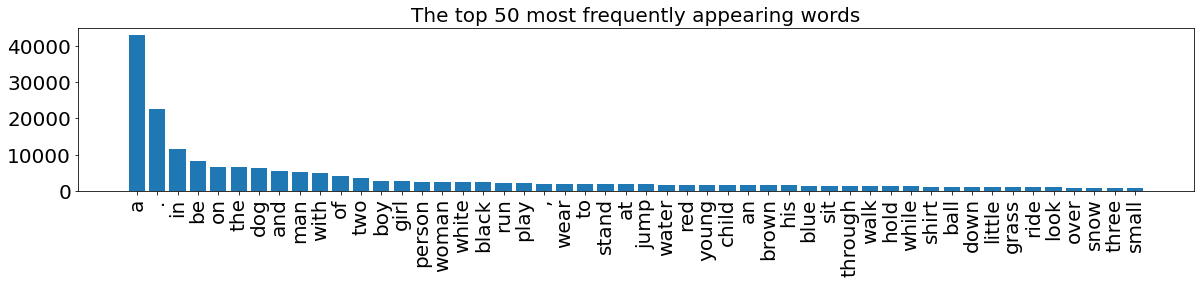

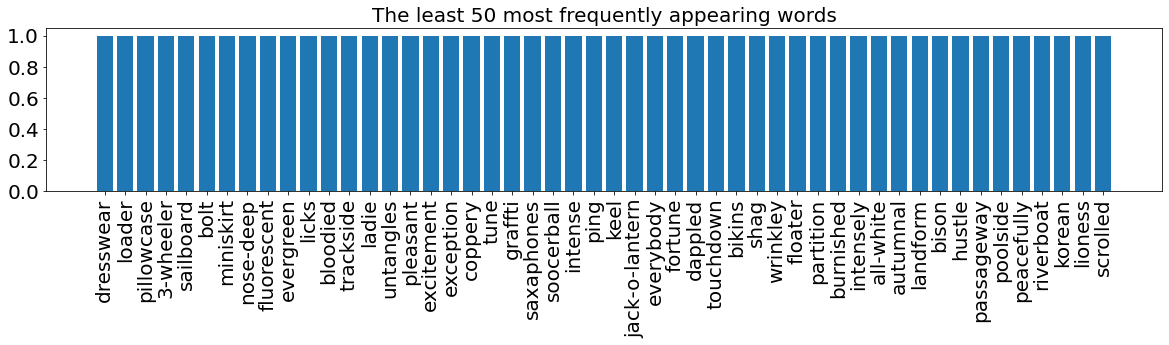

In [ ]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

<b>In order to clean the caption, We will create three functions that:<br>

<b><i>remove punctuation<br>
<b><i>remove single character<br>
<b><i>remove numeric characters<br>

In [ ]:
import string
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)

print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)


print("\nRemove words with numeric values..")
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)



Remove punctuations..

Remove a single character word..

Remove words with numeric values..


<b>Clean all captions : Using the three functions created above.

In [ ]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_ImgCaptions.caption.values):
    newcaption = text_clean(caption)
    df_ImgCaptions["caption"].iloc[i] = newcaption

<b>After cleaning, the vocabularly size get reduced by about 50

Vocabulary Size: 5514


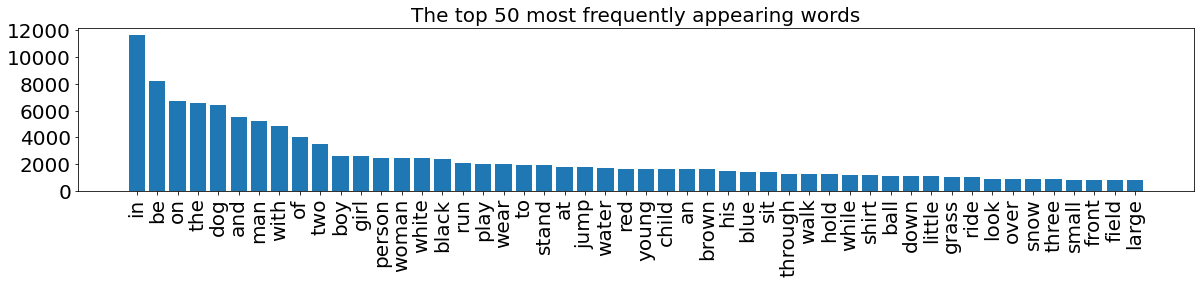

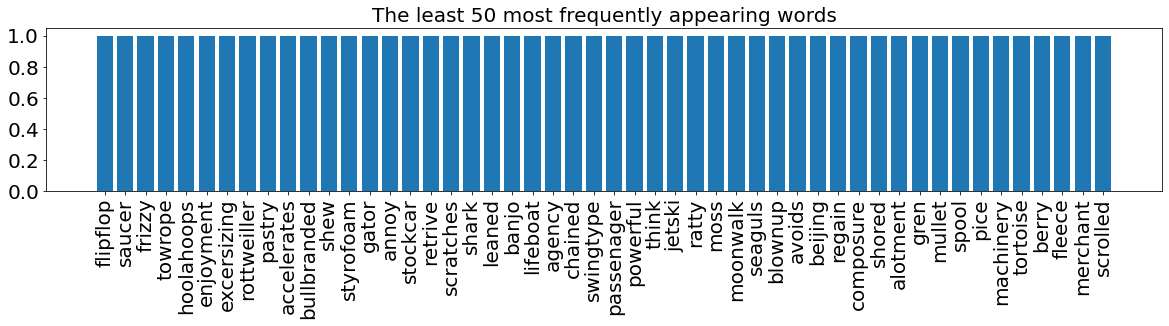

In [ ]:
dfword = df_word(df_ImgCaptions)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

# Plot at least two samples and their captions

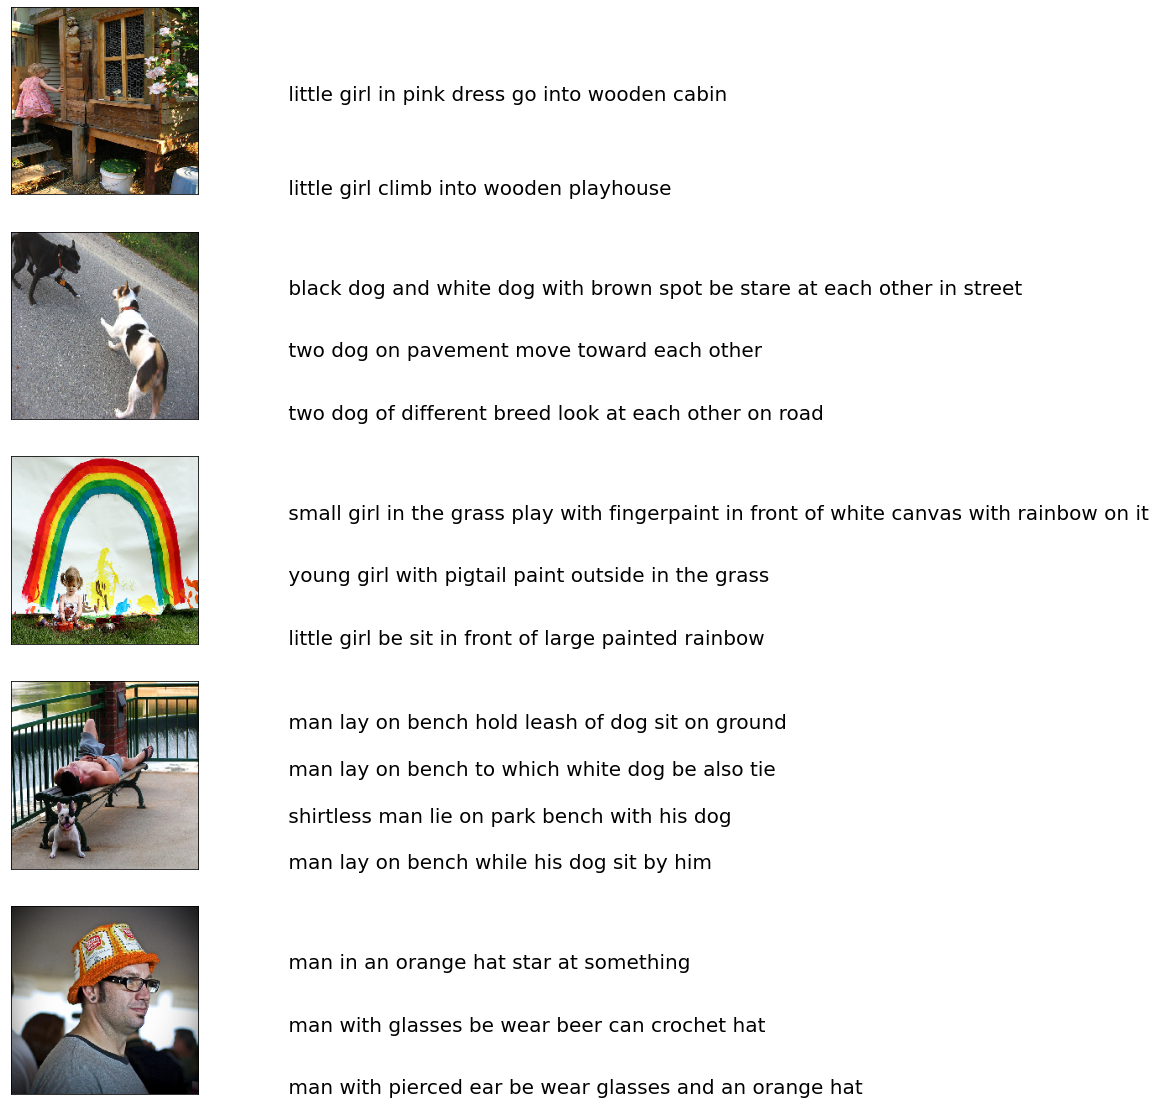

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[:npic]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_ImgCaptions["caption"].loc[df_ImgCaptions["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [ ]:
# saving the dataframe
df_ImgCaptions['filename']=df_ImgCaptions['filename'].map(lambda x: x.rstrip('.jpg'))
np.savetxt("captions.txt", df_ImgCaptions, fmt = "%s")

# Train Set

In [ ]:
# loading the doc
def load_doc(filename):
    file = open(filename , 'r')
    text = file.read()
    file.close()
    return text

# this function is used for to get train image description from our dataset

def load_clean_descriptions(filename , dataset):
    doc = load_doc(filename)
    descriptions = dict()
    
    for line in doc.split('\n'):
        tokens = line.split(' ')
        image_id , image_desc = tokens[0] , tokens[1:]
        
        if image_id in dataset:
            
            if image_id not in descriptions:
                descriptions[image_id] = list()
            
            # we add two tage at start and at end of the descitpion to identify to start and 
            # end of desc.
            desc = 'startseq '+ ' '.join(image_desc)+ ' endseq'
            descriptions[image_id].append(desc)
            
    return descriptions


# laod photo features
def load_photo_features(filename , dataset):
    all_features = load(open(filename,'rb'))
    features = {k+'.jpg' : all_features[k] for k in dataset}
    return features

In [ ]:
train = set(df_ImgCaptions['filename'][:127125])
print('len of train image',len(train))

len of train image 8021


In [ ]:
# traininset makinng and set startseq and endseq tag in descriptions
train_descriptions = load_clean_descriptions('captions.txt' , train)

In [ ]:
train_descriptions['1001773457_577c3a7d70']
#descriptions['1001773457_577c3a7d70']

['startseq  two dog of different breed look at each other on road endseq',
 'startseq  two dog on pavement move toward each other endseq',
 'startseq  black dog and white dog with brown spot be stare at each other in street endseq']

In [ ]:
print('len of train descriptions' , len(train_descriptions))

len of train descriptions 8021


In [ ]:
train = pd.DataFrame(train)

In [ ]:
train2 = train[0].apply(lambda x : x.replace('.jpg' , '')) # remove jpg sign

In [ ]:
# train features means feautures from training images
train_features = load_photo_features('features.pkl' , train2)
print('photos train :',len(train_features))

KeyError: '2258277193_586949ec62.1'

# Add start and end sequence tokens

In [ ]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_ImgCaptions0 = copy(df_ImgCaptions)
df_ImgCaptions0["caption"] = add_start_end_seq_token(df_ImgCaptions["caption"])
df_ImgCaptions0.head(5)
del df_ImgCaptions

# Training the Model

In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each description for the image
	for desc in desc_list:
		# encode the sequence
		seq = tokenizer.texts_to_sequences([desc])[0]
		# split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# store
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)

# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	# compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	model.summary()
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
	# loop for ever over images
	while 1:
		for key, desc_list in descriptions.items():
			# retrieve the photo feature
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
			yield [[in_img, in_seq], out_word]

# load training dataset (6K)
filename = './Flickr_TextData/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# define the model
model = define_model(vocab_size, max_length)
# train the model, run epochs manually and save after each epoch
epochs = 5
steps = len(train_descriptions)
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
	# fit for one epoch
	model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	model.save('model_' + str(i) + '.h5')

In [ ]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

In [ ]:
# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

In [ ]:
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

In [ ]:
# load training dataset (6K)
filename = 'train.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

In [ ]:
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

In [ ]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each image identifier
	for key, desc_list in descriptions.items():
		# walk through each description for the image
		for desc in desc_list:
			# encode the sequence
			seq = tokenizer.texts_to_sequences([desc])[0]
			# split one sequence into multiple X,y pairs
			for i in range(1, len(seq)):
				# split into input and output pair
				in_seq, out_seq = seq[:i], seq[i]
				# pad input sequence
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
				# encode output sequence
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
				# store
				X1.append(photos[key][0])
				X2.append(in_seq)
				y.append(out_seq)
	return array(X1), array(X2), array(y)

In [ ]:
# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

In [ ]:
# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	print(model.summary())
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

In [ ]:
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)
 

In [ ]:
# train dataset

# load training dataset (6K)
filename = 'Flickr_TextData/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)
 

In [ ]:
max_length = max_length(train_descriptions)

In [ ]:
max_length

In [ ]:
# dev dataset
 
# load test set
filename = 'Flickr_TextData/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)


In [ ]:
# fit model
 
# define the model
model = define_model(vocab_size, max_length)
# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# fit model
model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

In [ ]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

In [ ]:
#Evaluate Model

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text


# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# Image preparation

In [ ]:
df_ImgCaptions0[:5]

In [ ]:
import os
mylist = ""
with open("imageList.txt", "w", encoding="utf-8") as file:
    for eachfile in os.listdir("./Flicker8k_Dataset"):
        mylist += eachfile + "\n"
    file.write(mylist)

In [ ]:
import pandas as pd
df = pd.read_fwf('imageList.txt', header=None)

In [ ]:
#df = pd.DataFrame(np.random.randn(100, 2))
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

In [ ]:
import random
file=open("imageList.txt","r")
data=list()
for line in file:
    data.append(line)
file.close()
random.shuffle(data)
train_data = data[:int((len(data)+1)*.80)] #Remaining 80% to training set
test_data = data[int((len(data)+1)*.80):] #Splits 20% data to test set

In [ ]:
def split_huge_file(file,out1,out2,percentage=0.75,seed=123):
    """Splits a file in 2 given the approximate `percentage` to go in the large file."""
    random.seed(seed) 
    with open(file, 'r',encoding="utf-8") as fin,open(out1, 'w') as train_data,open(out2, 'w') as test_data:
        for line in fin:
            r = random.random()  
            if r < percentage: 
                train_data.write(line) 
            else: 
                test_data.write(line)
                

# function to read text from .txt file 
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [ ]:
split_huge_file("imageList.txt","train.txt","test.txt" )

In [ ]:
train_file_data = readTextFile("train.txt")
test_file_data = readTextFile("test.txt")

In [ ]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [ ]:
train = train_file_data.split("\n")[:-1]
test = test_file_data.split("\n")[:-1]

In [ ]:
df_ImgCaptions0[:5]

# 3. Model Building (7 mark)

a. Use Pretrained Squeezenet model trained on ImageNet dataset (available publicly on google) for image feature extraction.<br>
b. Create 3 layered LSTM layer model and other relevant layers for image caption generation.<br>
c. Add L2 regularization to all the LSTM layers.<br>
d. Add one layer of dropout at the appropriate position and give reasons.<br>
e. Choose the appropriate activation function for all the layers.<br>
f. Print the model summary.

In [ ]:
import torchvision.models as models
model_transfer = models.squeezenet1_0(pretrained=True)

In [ ]:
import torchvision.models as models
import torch

In [ ]:

#SqueezeNet
#model = models.squeezenet1_1(pretrained=True)
#pthfile = 'squeezenet1_1-b8a52dc0.pth'
#model.load_state_dict(torch.load(pthfile))
model_transfer = models.squeezenet1_1(pretrained=True)
print(model_transfer)

In [ ]:
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
 
# extract features from each photo in the directory
def extract_features(directory):
	# load the model
	model = VGG16()
	# re-structure the model
	model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
	# summarize
	print(model.summary())
	# extract features from each photo
	features = dict()
	for name in listdir(directory):
		# load an image from file
		filename = directory + '/' + name
		image = load_img(filename, target_size=(224, 224))
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		# reshape data for the model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the VGG model
		image = preprocess_input(image)
		# get features
		feature = model.predict(image, verbose=0)
		# get image id
		image_id = name.split('.')[0]
		# store feature
		features[image_id] = feature
		print('>%s' % name)
	return features
 
# extract features from all images
directory = 'Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))

In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
filename = 'Flickr_TextData/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)

In [ ]:
# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping
 
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

In [ ]:
import string
 
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping
 
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)
 
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc
 
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()
 
filename = 'Flickr_TextData/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'descriptions.txt')

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def SqueezeNet(self,feature_extract = True):
    """ Squeezenet
        Args:
          feature_extracting (Boolean) : True if feature extracking and False if fine-tuning
        Returns a tuple of :
          Squeezenet  pretained model and it's expected input size
    """

    self.model = torchvision.models.squeezenet1_0(pretrained=True)
    self.set_parameter_requires_grad(self.model,feature_extract)
    self.model.classifier[1] = nn.Conv2d(512, self.num_classes, kernel_size=(1,1), stride=(1,1))
    self.model.num_classes = self.num_classes
    self.input_size = 224

    return self.model, self.input_size

In [ ]:
import numpy as np
import keras 
from keras_applications import vgg16
from keras_squeezenet import SqueezeNet
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image

model = SqueezeNet()

In [ ]:
#pip install git+https://github.com/rcmalli/keras-squeezenet.git


In [ ]:
#pip install keras_applications

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
from collections import OrderedDict

In [ ]:
# Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout.# Defin 
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 1024)),
                          ('drop', nn.Dropout(p=0.5)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier
model

In [ ]:
from torch import optim

In [ ]:
# Train the classifier layers using backpropagation using the pre-trained network to get the features.
# Track the loss and accuracy on the validation set to determine the best hyperparameters.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

epochs = 8
steps = 0
cuda = torch.cuda.is_available()

if cuda:
    model.cuda()
else:
    model.cpu()
    
running_loss = 0
accuracy = 0

start = time.time()
print('Training started')

for e in range(epochs):
    
    train_mode = 0
    valid_mode = 1
    
    for mode in [train_mode, valid_mode]:   
        if mode == train_mode:
            model.train()
        else:
            model.eval()
            
        pass_count = 0
        
        for data in dataloaders[mode]:
            pass_count += 1
            inputs, labels = data
            if cuda == True:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()
            # Forward
            output = model.forward(inputs)
            loss = criterion(output, labels)
            # Backward
            if mode == train_mode:
                loss.backward()
                optimizer.step()                

            running_loss += loss.item()
            ps = torch.exp(output).data
            equality = (labels.data == ps.max(1)[1])
            accuracy = equality.type_as(torch.cuda.FloatTensor()).mean()

        if mode == train_mode:
            print("\nEpoch: {}/{} ".format(e+1, epochs),
                  "\nTraining Loss: {:.4f}  ".format(running_loss/pass_count))
        else:
            print("Validation Loss: {:.4f}  ".format(running_loss/pass_count),
              "Accuracy: {:.4f}".format(accuracy))

        running_loss = 0

time_elapsed = time.time() - start
print("\nTotal time: {:.0f}m {:.0f}s".format(time_elapsed//60, time_elapsed % 60))

In [ ]:
from keras.models import Model
model = Model(inputs=squeezenet.inputs, outputs=squeezenet.layers[-2].output)

In [ ]:
import torch.nn as nn

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
feature_extract = False
use_pretrained = True
model_ft = models.squeezenet1_0(pretrained=use_pretrained)
set_parameter_requires_grad(model_ft, feature_extract)
model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
model_ft.num_classes = num_classes
input_size = 224